In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np

from voxmap import create_voxmap
from planning_utils import a_star, heuristic, create_grid
from planning_utils import a_star3D, heuristic3D, create_grid25
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [6]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()

In [7]:
class MotionPlanning(Drone):

    def __init__(self, connection):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        self.in_mission = True
        self.check_state = {}

        # initial state
        self.flight_state = States.MANUAL

        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)

    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            local_pos = self.local_position[:3]
            local_pos[2] = local_pos[2] * -1
            #print("local_position_callback, wp transition:", np.linalg.norm(self.target_position[:3] - local_pos), self.target_position, local_pos)
            #print("local_position_callback, wp transition:", self.target_position[:3], self.local_position[:3])
            if np.linalg.norm(self.target_position[:3] - local_pos) < 1.0:
                if len(self.waypoints) > 0:                    
                    self.waypoint_transition()
                else:
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        self.flight_state = States.PLANNING
        print("Searching for a path ...")
        TARGET_ALTITUDE = 5
        SAFETY_DISTANCE = 5

        self.target_position[2] = TARGET_ALTITUDE

        # TODO: read lat0, lon0 from colliders into floating point values
        
        # TODO: set home position to (lon0, lat0, 0)

        # TODO: retrieve current global position
 
        # TODO: convert to current local position using global_to_local()
        
        print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                         self.local_position))
        # Read in obstacle map
        data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        
        # Define a grid for a particular altitude and safety margin around obstacles
        grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
        # Define starting point on the grid (this is just grid center)
        grid_start = (-north_offset, -east_offset)
        # TODO: convert start position to current position rather than map center
        
        # Set goal as some arbitrary position on the grid
        grid_goal = (-north_offset + 10, -east_offset + 10)
        # TODO: adapt to set goal as latitude / longitude position and convert

        # Run A* to find a path from start to goal
        # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
        # or move to a different search space such as a graph (not done here)
        print('Local Start and Goal: ', grid_start, grid_goal)
        path, _ = a_star(grid, heuristic, grid_start, grid_goal)
        # TODO: prune path to minimize number of waypoints
        # TODO (if you're feeling ambitious): Try a different approach altogether!

        # Convert path to waypoints
        waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]
        # Set self.waypoints
        self.waypoints = waypoints
        # TODO: send waypoints to sim (this is just for visualization of waypoints)
        self.send_waypoints()

    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        # Only required if they do threaded
        # while self.in_mission:
        #    pass

        self.stop_log()

In [8]:
def main():
    print("main")
    #parser = argparse.ArgumentParser()
    #parser.add_argument('--port', type=int, default=5760, help='Port number')
    #parser.add_argument('--host', type=str, default='127.0.0.1', help="host address, i.e. '127.0.0.1'")
    #args = parser.parse_args()

    conn = MavlinkConnection('tcp:{0}:{1}'.format('127.0.0.1', 5760), timeout=60)
    drone = MotionPlanning(conn)
    time.sleep(1)

    drone.start()

In [9]:
from planning_utils import a_star

In [10]:
def plot(grid, start_ne, goal_ne, goal_list=None, path=None):
    plt.figure(figsize=(24, 12))
    plt.imshow(grid, cmap='Greys', origin='lower')
    
    # For the purposes of the visual the east coordinate lay along
    # the x-axis and the north coordinates long the y-axis.
    plt.plot(start_ne[1], start_ne[0], 'gx', markersize=5, markeredgewidth=5)
    plt.plot(goal_ne[1], goal_ne[0], 'rx', markersize=5, markeredgewidth=5)
    
    for g in goal_list:
        plt.plot(g[1], g[0], 'bo', markeredgewidth=2)

    if path is not None:
        pp = np.array(path)
        #pp = np.array(parr)
        plt.plot(pp[:, 1], pp[:, 0], 'g')

    plt.xlabel('EAST')
    plt.ylabel('NORTH')
    plt.show()    

In [11]:
def plot3D(voxmap, vox_start, vox_goal, path=None):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    #ax.voxels(voxmap, edgecolor='k')
    ax.set_xlim(voxmap.shape[0], 0)
    ax.set_ylim(0, voxmap.shape[1])
    # add 100 to the height so the buildings aren't so tall
    ax.set_zlim(0, voxmap.shape[2])

    #limi = 2
    if path is not None:
        pp = np.array(path)
        #ax.plot(pp[:limi, 1], pp[:limi, 0], pp[:limi, 2], 'g')
        ax.plot(pp[:, 1], pp[:, 0], pp[:, 2], 'g')
    this didnt draw the path
            

    # path_pairs = zip(path[:-1], path[1:])
    # for (n1, n2) in path_pairs:
    #     Axes3D.plot([n1[1], n2[1]], [n1[0], n2[0]], n1[2],n2[2], 'green',linewidth=3)
    #plt.plot([path[-1][1], goal[1] - emin], [path[-1][0] - nmin, goal[0] - nmin],linewidth=3)    

    ax.plot([vox_start[0]], [vox_start[1]], [vox_start[2]], 'gx',markersize=10,markeredgewidth=3)
    ax.plot([vox_goal[0]], [vox_goal[1]], [vox_goal[2]], 'rx',markersize=10,markeredgewidth=3)


    plt.xlabel('North')
    plt.ylabel('East')

    plt.show()

In [12]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

def prune_path(path, voxel_size=None):
    max_p = 20 // voxel_size
    print("max_p:%s, vxs:%s" %(max_p, voxel_size))
    if voxel_size is None or voxel_size == 1:
        pruned_path = [p for p in path]
    else:
        pruned_path = [(p[0] * voxel_size, p[1] * voxel_size,p[2] * voxel_size) for p in path]
    # TODO: prune the path!
    i = 0
    ri = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        if collinearity_check(p1,p2,p3) and ri < max_p:
            pruned_path.remove(pruned_path[i+1])
            ri += 1
        else:
            i += 1
            ri = 0
    return pruned_path

main
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.3974533   37.7924804    0.       ], position [-122.3973976   37.7924281    0.181    ], local position [-5.81940794  4.95495701 -0.18270686]
grid2.5 shape =  (921, 921)
North offset = -316, east offset = -445, grid shape = (921, 921)
North offvox = -316, east offvox = -445, vox shape = (184, 184, 50)
grid25
[[176. 176. 176. ...   0.   0.   0.]
 [176. 176. 176. ...   0.   0.   0.]
 [176. 176. 176. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
lon lat:  (37.79248, -122.39745)  vs  (316, 445)
lla:  37.7924281 -122.3973976 0.181
gh:  [-122.3974533   37.7924804    0.       ]
gp:  [-122.3973976   37.7924281    0.181    ]
lp: [-5.771062    4.94152793 -0.181     ]
gsf:  310.228938001208 449.94152793404646
gs:  (310, 450, 5) vs:  (62, 90, 1)
change [0.51199937 0.12055661 0.15097484]
goal:  (-

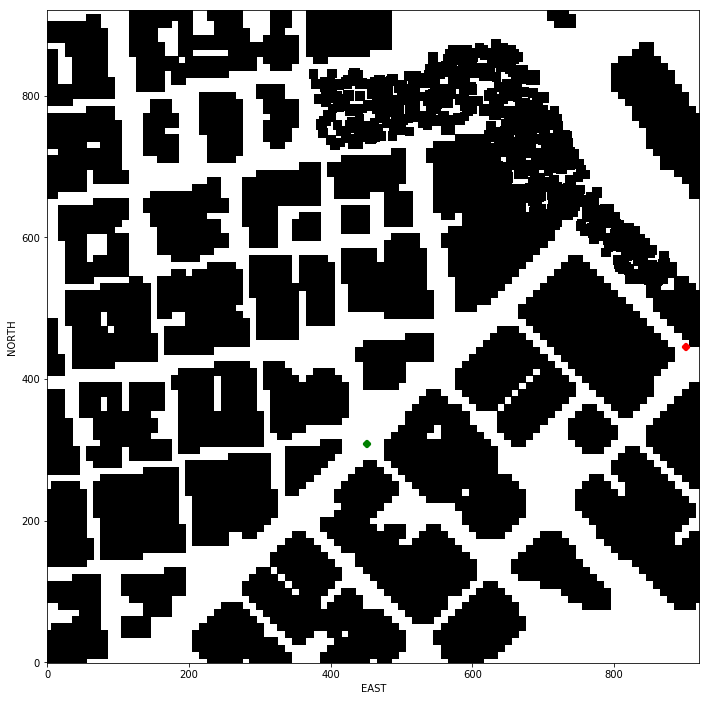

goal type: <class 'tuple'>, start type:<class 'tuple'>
D, DA: 2000 28071 CC: 35.96983379061813 HC: 67.7566303550217 QC: 103.72646414563982 CN: (83, 116, 5)
D, DA: 3000 38599 CC: 45.31297954112575 HC: 59.241911729260266 QC: 104.55489127038601 CN: (77, 127, 5)
D, DA: 6000 78185 CC: 9.19615242270663 HC: 96.23778298304924 QC: 105.43393540575588 CN: (69, 93, 4)
D, DA: 9000 113636 CC: 48.50500321762132 HC: 57.80311861943435 QC: 106.30812183705567 CN: (90, 125, 7)
D, DA: 11000 138772 CC: 50.3122505832667 HC: 56.63154574418054 QC: 106.94379632744725 CN: (88, 127, 9)
D, DA: 12000 151358 CC: 41.40522711209203 HC: 65.87831517751084 QC: 107.28354228960288 CN: (92, 116, 3)
Found a path.
91 107.49062303522459
max_p:4, vxs:5
24


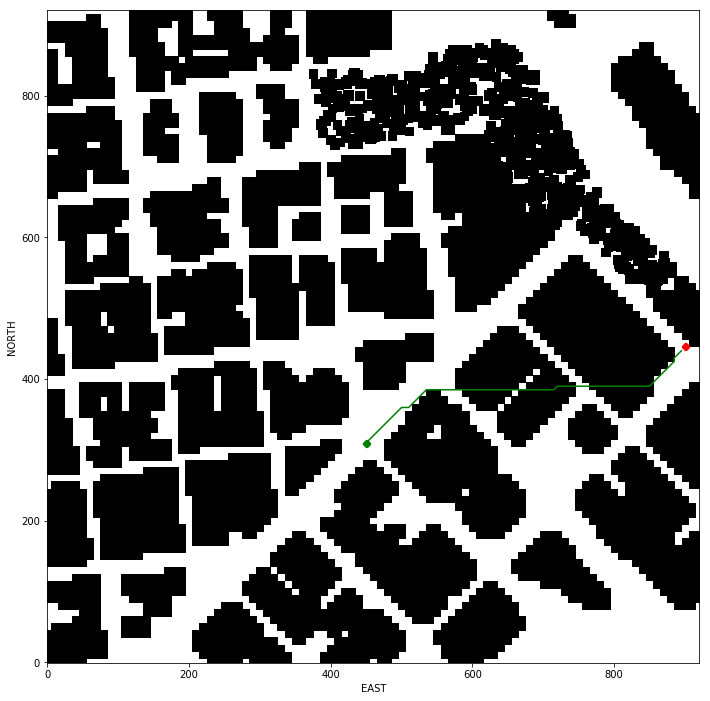

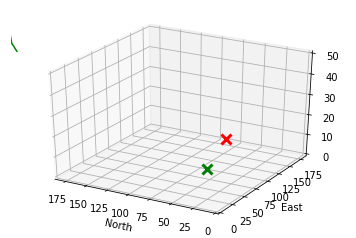

A* path:
(62, 90, 1) False
(63, 91, 1) False
(64, 92, 1) False
(65, 93, 1) False
(66, 94, 1) False
(67, 95, 1) False
(68, 96, 2) False
(69, 97, 3) False
(70, 98, 4) False
(71, 99, 5) False
(72, 100, 6) False
(72, 101, 6) False
(72, 102, 6) False
(73, 103, 7) False
(74, 104, 7) False
(75, 105, 8) False
(76, 106, 9) False
(77, 107, 10) False
(77, 108, 10) False
(77, 109, 10) False
(77, 110, 10) False
(77, 111, 10) False
(77, 112, 10) False
(77, 113, 10) False
(77, 114, 10) False
(77, 115, 10) False
(77, 116, 10) False
(77, 117, 10) False
(77, 118, 10) False
(77, 119, 10) False
(77, 120, 10) False
(77, 121, 10) False
(77, 122, 10) False
(77, 123, 10) False
(77, 124, 10) False
(77, 125, 10) False
(77, 126, 10) False
(77, 127, 10) False
(77, 128, 10) False
(77, 129, 10) False
(77, 130, 10) False
(77, 131, 10) False
(77, 132, 10) False
(77, 133, 10) False
(77, 134, 10) False
(77, 135, 10) False
(77, 136, 10) False
(77, 137, 10) False
(77, 138, 10) False
(77, 139, 10) False
(77, 140, 10) Fals

In [13]:
def plan_path(self, twoD=False):
    self.flight_state = States.PLANNING
    print("Searching for a path ...")
    TARGET_ALTITUDE = 5
    SAFETY_DISTANCE = 5
    VOXEL_SIZE = 5
    MAX_ALTITUDE = 250

    self.target_position[2] = TARGET_ALTITUDE

    # TODO: read lat0, lon0 from colliders into floating point values

    # TODO: set home position to (lon0, lat0, 0)

    # TODO: retrieve current global position

    # TODO: convert to current local position using global_to_local()

    print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                     self.local_position))
    # Read in obstacle map
    data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
    if not twoD:
        voxmap, north_offvox, east_offvox = create_voxmap(data, safety_distance=SAFETY_DISTANCE, max_altitude=MAX_ALTITUDE, voxel_size=VOXEL_SIZE)
    # Define a grid for a particular altitude and safety margin around obstacles
    grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
    grid25, _,_ = create_grid25(data, SAFETY_DISTANCE)
    print("grid2.5 shape = ", grid25.shape)
    print("North offset = {0}, east offset = {1}, grid shape = {2}".format(north_offset, east_offset, grid.shape))
    print("North offvox = {0}, east offvox = {1}, vox shape = {2}".format(north_offvox, east_offvox, voxmap.shape))

    print("grid25")
    print(grid25)
    # Define starting point on the grid (this is just grid center)
    with open('colliders.csv') as f:
        first_line = f.readline().strip()
    latlon = first_line.split(',')
    lon0 = float(latlon[0].strip().split(' ')[1])
    lat0 = float(latlon[1].strip().split(' ')[1])      
    #grid_start = (-north_offset, -east_offset)
    # TODO: convert start position to current position rather than map center
    self.set_home_position(lat0, lon0, 0)
    print("lon lat: ", (lon0, lat0), " vs ", (-north_offset, -east_offset))    
    print("lla: ",self._latitude, self._longitude, self._altitude)
    print("gh: ",self.global_home)
    print("gp: ",self.global_position)
    local_pos = global_to_local(self.global_position, global_home=self.global_home)
    print("lp:", local_pos)
    north, east, att = local_pos
    print("gsf: ", (north - north_offset), (east - east_offset))

    #2d
    #3d
    if twoD:
        grid_start = (int(np.rint(north - north_offset)), int(np.rint(east - east_offset)))
    else:
        grid_start = (int(np.rint(north - north_offset)), int(np.rint(east - east_offset)), int(np.rint(self.global_position[2])) + TARGET_ALTITUDE)
    
    #grid_start = (316, 475, 30)
    vox_start = (grid_start[0] // VOXEL_SIZE,
             grid_start[1] // VOXEL_SIZE,
             grid_start[2] // VOXEL_SIZE)
    print("gs: ",grid_start, "vs: ", vox_start)
    

    
    # Set goal as some arbitrary position on the grid
    #grid_goal = (-north_offset + 10, -east_offset + 10)
    # TODO: adapt to set goal as latitude / longitude position and convert
    # grid_goal = (grid_start[0] + 10, grid_start[1] + 10)
    #goal = (-122.400600, 37.793401, 0)
    #goal = (lat0 + 0.0001, lon0 + 0.00001, 0)
    dist_idx = 100.0
    goal_obs = True
    goal_try = 0
    goal_list = []
    voxel_shape = voxmap.shape
    while goal_obs and goal_try < 100:
        goal_try += 1
        change = np.random.rand(3)
        change[1:2] -= 0.5
        print("change", change)
        goal = (self.global_position[0] + change[0] / dist_idx,
                self.global_position[1] + change[1] / (dist_idx),
                self.global_position[2] + change[2] * float(MAX_ALTITUDE))
        print("goal: ", goal)
        local_goal = global_to_local(goal, global_home=self.global_home)
        print("lg: ", local_goal)
        ng, eg, ag = local_goal
        print("ggf: ", (ng - north_offset), (eg - east_offset))
        #2d vs 3d
        if twoD:
            grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)))
        else:
            goal_north = int(np.rint(ng - north_offset))
            goal_east = int(np.rint(eg - east_offset))
            grid25shape = grid25.shape
            if goal_north < 1:
                goal_north = 1
            elif goal_north > grid25shape[0] - 2:
                goal_north = grid25shape[0] - 2
            if goal_east < 1:
                goal_east = 1
            elif goal_east > grid25shape[1] - 2:
                goal_east = grid25shape[1] - 2                
            goal_alt= int(np.rint(grid25[goal_north, goal_east] + SAFETY_DISTANCE))
            #grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)), int(np.rint(goal[2])))
            grid_goal = (goal_north, goal_east, goal_alt)

#        grid_goal = (310,500,100)
        
        # Top of the next building
#         grid_goal = (grid_start[0] - 10,
#                      grid_start[1] + 50,
#                      grid_start[2] + 100)

        # To the hole
        #grid_goal = (320, 545, 5)
#         grid_goal = (grid_start[0] + 5,
#                      grid_start[1] + 100,
#                      grid_start[2] + 30)


#         grid_goal = (grid_start[0] - 10,
#                      grid_start[1] + 10,
#                      grid_start[2] + 10)

        vox_goal = (grid_goal[0] // VOXEL_SIZE,
                     grid_goal[1] // VOXEL_SIZE,
                     grid_goal[2] // VOXEL_SIZE)
        
        if vox_goal[0] >= voxel_shape[0]:
            vox_goal = (voxel_shape[0] - 1, vox_goal[1], vox_goal[2])
        elif vox_goal[0] < 1:
            vox_goal = (1, vox_goal[1], vox_goal[2])
        if vox_goal[1] >= voxel_shape[1]:
            vox_goal = (grid_goal[0], voxel_shape[1] - 1, vox_goal[2])
        elif vox_goal[1] < 1:
            vox_goal = (vox_goal[0], 1, vox_goal[2])
                    
        print("gg: ",grid_goal, " vg: ", vox_goal, goal_obs)
        
        if twoD:
            goal_obs = grid[grid_goal[0], grid_goal[1]]
        else:
            goal_obs = voxmap[vox_goal[0], vox_goal[1], vox_goal[2]]
        print("gg: ",grid_goal, " vg: ", vox_goal, goal_obs)
        if goal_obs:
            goal_list.append(grid_goal)
    
    #grid_goal = (grid_start[0] + 10, grid_start[1] + 10,0)    
    #print("gg: ",grid_goal, " vg: ", vox_goal)
    # Run A* to find a path from start to goal
    # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
    # or move to a different search space such as a graph (not done here)
    print('Grid Start and Goal: ', grid_start, grid_goal)
    print('Vox Start and Goal: ', vox_start, vox_goal)
    plot(grid, grid_start, grid_goal, goal_list=goal_list)
    #plot3D(voxmap, vox_start, vox_goal)
    # 2d vs 3d
    if twoD:
        path, cost = a_star(grid, heuristic, grid_start, grid_goal)
    else:
        path, cost = a_star3D(voxmap, heuristic3D, vox_start, vox_goal)
    print(len(path), cost)
    #if VOXEL_SIZE == 1:
    #    plot(grid, grid_start, grid_goal, goal_list=[], path=path)
        
    #plot3D(voxmap, vox_start, vox_goal, path=path)
    
    pruned_path = prune_path(path, VOXEL_SIZE)
    print(len(pruned_path))
    plot(grid, grid_start, grid_goal, goal_list=[], path=pruned_path)
    plot3D(voxmap, vox_start, vox_goal, path=pruned_path)
        
    print("A* path:")
    for p in path:
        print(p, voxmap[p[0], p[1], p[2]])
        
    print("Pruned_path:")
    for p in pruned_path:
        print(p)
    #    print(p, p.cost, p.delta, (p.delta[0] + north_offset, p.delta[1] + east_offset, TARGET_ALTITUDE, 0))
    # TODO: prune path to minimize number of waypoints
    # TODO (if you're feeling ambitious): Try a different approach altogether!

    # Convert path to waypoints
    #waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]
    if twoD:
        waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in pruned_path]
    else:
        waypoints = [[p[0] + north_offset, p[1] + east_offset, p[2], 0] for p in pruned_path]
        #waypoints = [[(p[0] * VOXEL_SIZE + north_offset), 
        #              (p[1] * VOXEL_SIZE + east_offset),
        #              (p[2] * VOXEL_SIZE), 0] for p in pruned_path]
    
    # Set self.waypoints
    self.waypoints = waypoints
    # TODO: send waypoints to sim (this is just for visualization of waypoints)
    self.send_waypoints()
MotionPlanning.plan_path = plan_path
main()

In [14]:
err

NameError: name 'err' is not defined

In [ ]:
main()

In [ ]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)

In [ ]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=0)

In [ ]:
#first_line = ""
with open('colliders.csv') as f:
    first_line = f.readline().strip()
print(first_line)    
latlon = first_line.split(',')
gs = float(latlon[0].strip().split(' ')[1])
ge = float(latlon[1].strip().split(' ')[1])
print(gs, ge)

In [ ]:
print(first_line.strip())